# Exploration 노드 17

# 라이브러리 불러오기

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, Input, Model
from tensorflow import image
from tensorflow import data
from tensorflow.keras import losses
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import random_rotation

# 데이터 준비

In [2]:
# import zipfile
# path_to_zip_file = os.getenv('HOME')+'/aiffel/Exploration/EX17/data/'
# with zipfile.ZipFile(path_to_zip_file + 'cityscapes.zip', 'r') as zip_ref:
#     zip_ref.extractall(path_to_zip_file + 'cityscapes')

In [3]:
data_path = os.getenv('HOME')+'/aiffel/Exploration/EX17/data/cityscapes/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


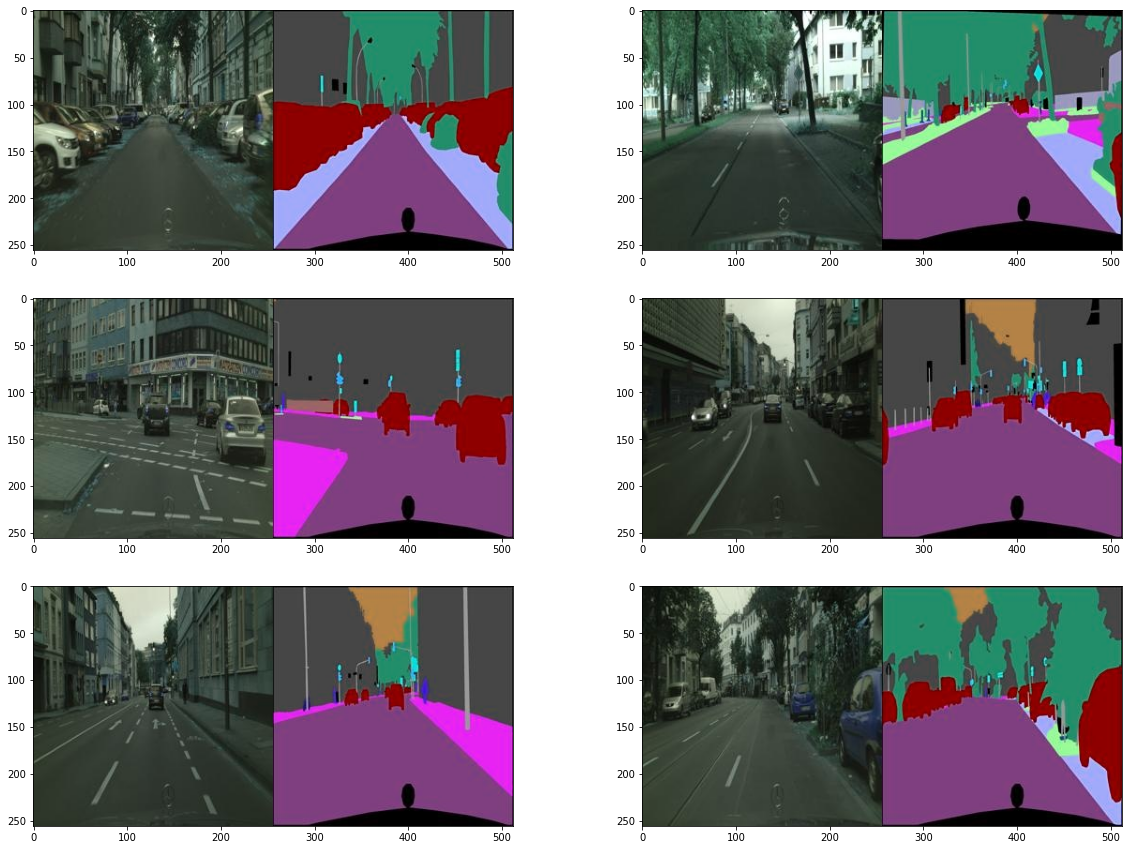

In [4]:
# 데이터 시각화
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [5]:
# 이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


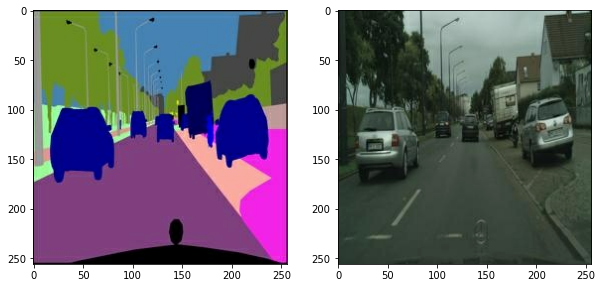

In [6]:
# 이미지 정규화
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

# 이미지 복원
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# 이미지 로딩 및 분할
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    photo = img[:, :w, :] 
    photo= tf.cast(photo, tf.float32)
    segmentation = img[:, w:, :] 
    segmentation = tf.cast(segmentation, tf.float32)
    return normalize(segmentation), normalize(photo)

f = data_path + os.listdir(data_path)[1]
segmentation, photo = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segmentation))
plt.subplot(1,2,2); plt.imshow(denormalize(photo))

In [7]:
# 이미지 데이터 증강 함수
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:] 

1. 두 이미지를 채널 축으로 쌓는다 (tf.concat)
2. 50% 확률로 __Refection padding__ 또는 __constant padding__이 30픽셀의 pad width 만큼 적용된다 (tf.pad)  
3. 2.의 결과에서 __(256,256,6) 크기를 가진 이미지를 임의로 잘라낸다__ (tf.image.random_crop)    
4. 3.의 결과를 50% 확률로 __가로로 뒤집는다__ (tf.image.random_flip_left_right)  
5. 4.의 결과를 50% 확률로 __세로로 뒤집는다__ (tf.image.random_flip_up_down)  
6. 5.의 결과를 50% 확률로 __회전시킨다__ (tf.image.rot90)  

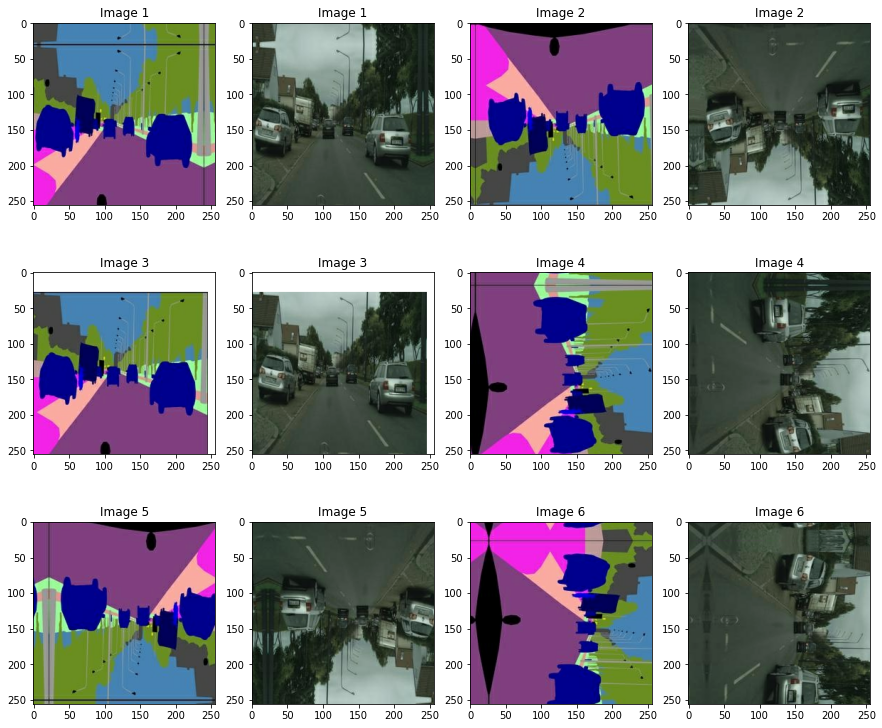

In [8]:
# 증강 데이터 시각화
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segmentation, augmented_photo = apply_augmentation(segmentation, photo)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segmentation)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_photo)); plt.title(f"Image {img_n}")
    img_n += 1

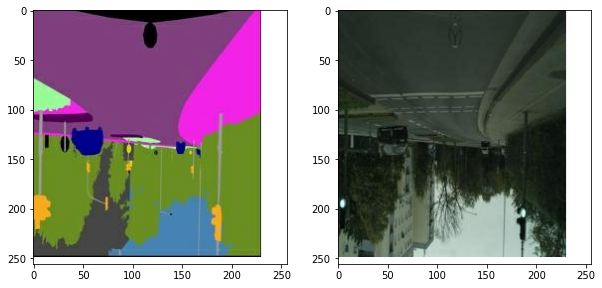

In [9]:
# 데이터셋 준비
def get_train(img_path):
    segmentation, photo = load_img(img_path)
    segmentation, photo = apply_augmentation(segmentation, photo)
    return segmentation, photo

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

# 샘플 시각화
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segmentation, photo = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segmentation[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(photo[0].astype(np.uint8))

## U-Net Generator 구성

In [10]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [12]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Discriminator 구성

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


In [15]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 모델 학습

In [16]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [17]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [18]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [19]:
train_images.take(1)

<TakeDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [20]:
# 모델 학습
EPOCHS = 15

generator = UNetGenerator()
discriminator = Discriminator()

history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}

for epoch in range(1, EPOCHS+1):
    for i, (segmentation, photo) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmentation, photo)

    history['g_loss'].append(g_loss.numpy())
    history['l1_loss'].append(l1_loss.numpy())
    history['d_loss'].append(d_loss.numpy())
    
    # 10회 반복마다 손실을 출력합니다.
    print(f"EPOCH[{epoch}]] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1]]             
Generator_loss:1.6307             
L1_loss:0.1988             
Discriminator_loss:0.4458

EPOCH[2]]             
Generator_loss:0.7353             
L1_loss:0.1842             
Discriminator_loss:0.8914

EPOCH[3]]             
Generator_loss:0.7205             
L1_loss:0.1898             
Discriminator_loss:0.9665

EPOCH[4]]             
Generator_loss:0.8875             
L1_loss:0.1923             
Discriminator_loss:0.8978

EPOCH[5]]             
Generator_loss:1.8535             
L1_loss:0.1787             
Discriminator_loss:0.7674

EPOCH[6]]             
Generator_loss:2.5961             
L1_loss:0.1737             
Discriminator_loss:0.5762

EPOCH[7]]             
Generator_loss:1.2616             
L1_loss:0.1637             
Discriminator_loss:0.8504

EPOCH[8]]             
Generator_loss:1.5622             
L1_loss:0.1585             
Discriminator_loss:0.4114

EPOCH[9]]             
Generator_loss:1.5066             
L1_loss:0.1858             
Discrimina

## 모델 테스트

Text(0.5, 1.0, 'Ground Truth')

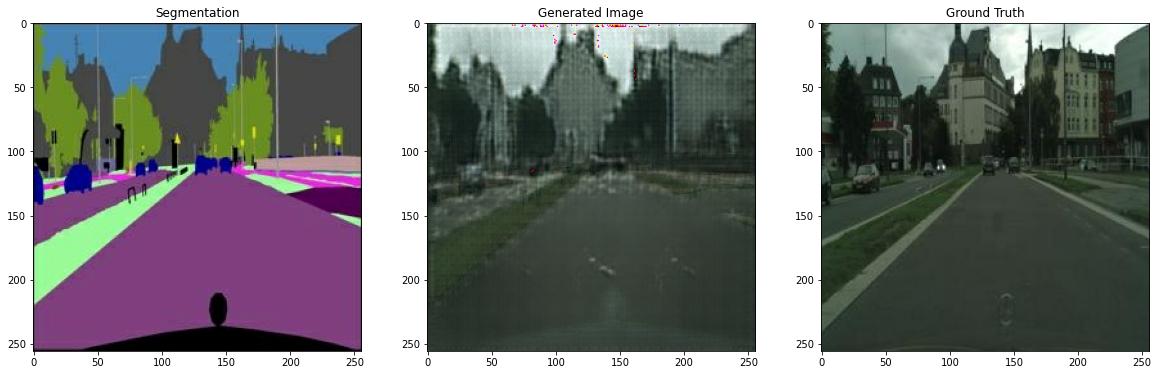

In [23]:
val_path = os.getenv('HOME')+'/aiffel/Exploration/EX17/data/cityscapes/cityscapes/val/'
test_ind = 1

f = data_path + os.listdir(val_path)[test_ind]
segmentation, photo = load_img(f)

pred = generator(tf.expand_dims(segmentation, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segmentation)); plt.title('Segmentation')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Generated Image')
plt.subplot(1,3,3); plt.imshow(denormalize(photo)); plt.title('Ground Truth')

## 학습과정 시각화

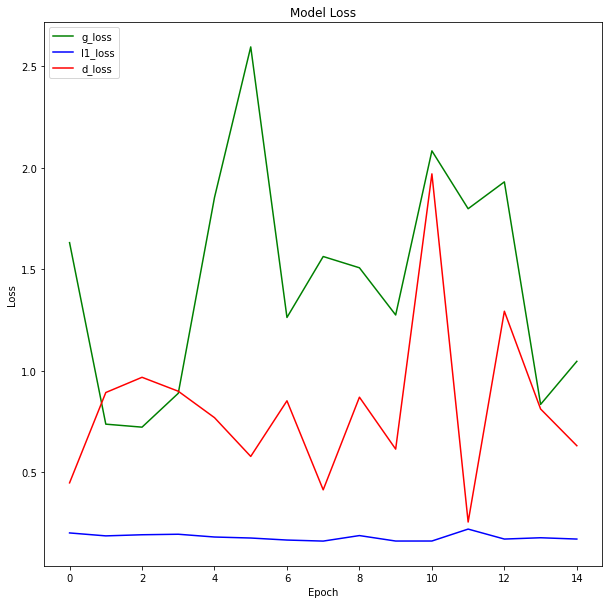

In [22]:
plt.figure(figsize=(10, 10))
plt.plot(history['g_loss'], 'g')
plt.plot(history['l1_loss'], 'b')
plt.plot(history['d_loss'], 'r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['g_loss', 'l1_loss', 'd_loss'], loc='upper left')

# 회고

* 의외로 Epoch는 많이 돌리지 않았는데도 결과가 생각보다 그럴싸하게 나왔다.
* U-Net Generator가 확실히 성능이 좋은 것 같다.
* 학습 시간을 더 길게 가지면 얼마나 좋아질까 궁금하다. 